In [30]:
import json

data = {}
for name in ["train", "test", "dev"]:
    with open(f"3class/{name}.json", encoding="utf-8") as file:
        data[name] = json.load(file)

In [31]:
import pandas as pd

train = pd.DataFrame(data["train"])
test = pd.DataFrame(data["test"])
dev = pd.DataFrame(data["dev"])

In [32]:
train.head()

,sent_id,text,label
0,201911-01-01,Philips 190G6,Neutral
1,201911-02-01,Med integrerte høyttalere som på ingen måte er...,Neutral
2,201911-02-02,Eller bedrar skinnet ?,Negative
3,201911-03-01,"De fleste skjermer har et diskret design , med...",Neutral
4,201911-03-02,Men 190G6 fra Philips er en helt annen historie .,Neutral


<AxesSubplot:>

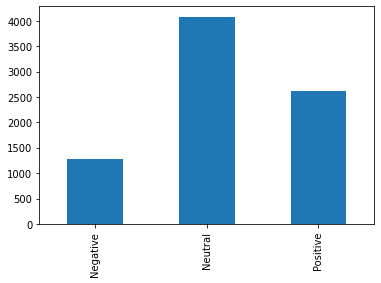

In [33]:
train["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

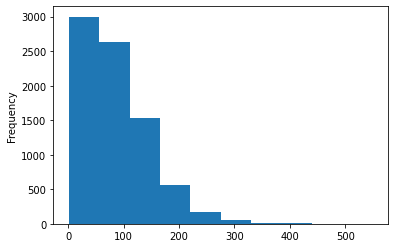

In [34]:
train["text"].str.len().plot.hist()

In [35]:
for data in [train, test, dev]:
    data["text"] = data["text"].str.lower()
    data["text"] = data["text"].str.strip()

In [36]:
train["text"].head()

0                                        philips 190g6
1    med integrerte høyttalere som på ingen måte er...
2                               eller bedrar skinnet ?
3    de fleste skjermer har et diskret design , med...
4    men 190g6 fra philips er en helt annen historie .
Name: text, dtype: object

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train["text"].values)

X = tokenizer.texts_to_sequences(train["text"].values)
X = pad_sequences(X)

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))

In [40]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 256)           1280000   
                                                                 
 dropout_1 (Dropout)         (None, 78, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 78, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [41]:
y = pd.get_dummies(train["label"]).values

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/10
160/160 [==============================] - 355s 2s/step - loss: 0.9502 - accuracy: 0.5478 - val_loss: 0.9268 - val_accuracy: 0.5697
Epoch 2/10
160/160 [==============================] - 562s 4s/step - loss: 0.7479 - accuracy: 0.6807 - val_loss: 0.8916 - val_accuracy: 0.6199
Epoch 3/10
160/160 [==============================] - 477s 3s/step - loss: 0.5261 - accuracy: 0.7889 - val_loss: 0.9514 - val_accuracy: 0.6317
Epoch 4/10
160/160 [==============================] - 403s 3s/step - loss: 0.3777 - accuracy: 0.8624 - val_loss: 1.0642 - val_accuracy: 0.6191
Epoch 5/10
160/160 [==============================] - 372s 2s/step - loss: 0.2809 - accuracy: 0.8961 - val_loss: 1.2040 - val_accuracy: 0.6168
Epoch 6/10
160/160 [==============================] - 315s 2s/step - loss: 0.2164 - accuracy: 0.9240 - val_loss: 1.4663 - val_accuracy: 0.6074
Epoch 7/10
160/160 [==============================] - 318s 2s/step - loss: 0.1709 - accuracy: 0.9392 - val_loss: 1.4667 - val_accuracy: 0.6121

In [48]:
from datetime import datetime

model.save(f"models/SA-RNN-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

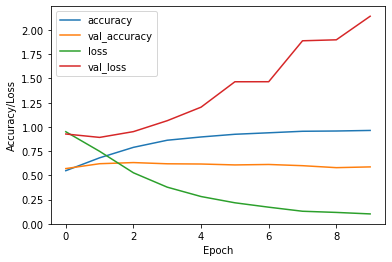

In [45]:
import matplotlib.pyplot as plt

# Plot accuracy and loss in the same plot
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.show()

In [46]:
import numpy as np

predictions = model.predict(X_test)
pos_count, neg_count, neu_count = 0, 0, 0
true_pos_count, true_neg_count, true_neu_count = 0, 0, 0

for i, prediction in enumerate(predictions):
    if np.argmax(prediction) == 2:
        pos_count += 1
    elif np.argmax(prediction) == 1:
        neg_count += 1
    else:
        neu_count += 1

    if np.argmax(y_test[i]) == 2:
        true_pos_count += 1
    elif np.argmax(y_test[i]) == 1:
        true_neg_count += 1
    else:
        true_neu_count += 1

print(f"Positive: {pos_count}")
print(f"Negative: {neg_count}")
print(f"Neutral: {neu_count}")
print(f"True Positive: {true_pos_count}")
print(f"True Negative: {true_neg_count}")
print(f"True Neutral: {true_neu_count}")

Positive: 619
Negative: 740
Neutral: 236
True Positive: 543
True Negative: 800
True Neutral: 252
